This notebook attempts to use the Gaussian Diffusion model described in TabDDPM, one model per domain.

Reference: https://github.com/yandex-research/tab-ddpm/blob/main/tab_ddpm/gaussian_multinomial_diffsuion.py

In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
import random

In [3]:
import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.append("../src/tab_ddpm/")

In [5]:
from torch.utils.data import TensorDataset, DataLoader

In [6]:
from gaussian_multinomial_diffusion import GaussianMultinomialDiffusion

In [7]:
from modules import MLPDiffusion

In [8]:
sys.path.append("../src/")
from vae_model import vae
from loss_functions import get_kld_loss, coral, compute_covariance, ZINORMLoss
from ffnzinb_model import ffnzinb

In [9]:
device = torch.device("cuda:0")

In [10]:
# seed things
random.seed(0)
np.random.seed(0)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

### Load Datasets

#### Cell Lines

In [11]:
cl_train_df = pd.read_csv("../data/diffusion_pretraining/cl_diffusion_train_sample0.csv", index_col=0)
cl_train_df.shape

(1569, 7776)

In [12]:
cl_test_df = pd.read_csv("../data/diffusion_pretraining/cl_diffusion_test_sample0.csv", index_col=0)
cl_test_df.shape

(175, 7776)

In [13]:
cl_train_dataset = TensorDataset(torch.tensor(cl_train_df.values), torch.tensor(cl_train_df.values))

In [14]:
cl_test_dataset = TensorDataset(torch.tensor(cl_test_df.values), torch.tensor(cl_test_df.values))

In [15]:
cl_train_dataloader = DataLoader(cl_train_dataset, batch_size=128, shuffle=True, num_workers=1, worker_init_fn=seed_worker, generator=g,)

In [16]:
cl_test_dataloader = DataLoader(cl_test_dataset, batch_size=128, shuffle=False, num_workers=1, worker_init_fn=seed_worker, generator=g,)

#### Patient Dataset

In [17]:
tcga_train_df = pd.read_csv("../data/diffusion_pretraining/tcga_diffusion_train_sample0.csv", index_col=0)
tcga_train_df.shape

(476, 7776)

In [18]:
tcga_test_df = pd.read_csv("../data/diffusion_pretraining/tcga_diffusion_test_sample0.csv", index_col=0)
tcga_test_df.shape

(120, 7776)

In [19]:
tcga_train_dataset = TensorDataset(torch.tensor(tcga_train_df.values), torch.tensor(tcga_train_df.values))

In [20]:
tcga_test_dataset = TensorDataset(torch.tensor(tcga_test_df.values), torch.tensor(tcga_test_df.values))

In [21]:
tcga_train_dataloader = DataLoader(tcga_train_dataset, batch_size=128, shuffle=True, num_workers=1, worker_init_fn=seed_worker, generator=g,)

In [22]:
tcga_test_dataloader = DataLoader(tcga_test_dataset, batch_size=128, shuffle=False, num_workers=1, worker_init_fn=seed_worker, generator=g,)

#### Train and Test loops for basic diffusion models per domain

In [23]:
# testing function
def testing_loop(test_dataloader, diffusion_model, device):
    avg_test_loss = 0.0
    for idx, batch in enumerate(test_dataloader):
        with torch.no_grad():
            inp = batch[0].to(device=device, dtype=torch.float32)
            noise = torch.randn_like(inp).to(device) # this is the label we use
            b = inp.shape[0]
            t, pt = diffusion_model.sample_time(b, device, 'uniform')
            inp_t = diffusion_model.gaussian_q_sample(inp, t, noise) # forward process
            model_out = diffusion_model._denoise_fn(inp_t, t) # predicted epsilon

            # MSE between predicted inp_pred after reverse diffusion and original input
            inp_pred = diffusion_model._predict_xstart_from_eps(inp_t, t, model_out)
            mse_loss = torch.nn.MSELoss()(inp_pred, inp)

            avg_test_loss += mse_loss.detach().item()

    return avg_test_loss/(idx+1)

In [24]:
# training function
def training_loop(train_dataloader, test_dataloader, epochs, diffusion_model, device, optimizer):
    train_losses = []
    for i in range(epochs):
        loss = 0.0
        avg_test_loss = ""
        for idx, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            inp = batch[0].to(device=device, dtype=torch.float32)
            noise = torch.randn_like(inp).to(device) # this is the label we use
            b = inp.shape[0]
            t, pt = diffusion_model.sample_time(b, device, 'uniform')
            inp_t = diffusion_model.gaussian_q_sample(inp, t, noise) # forward process
            model_out = diffusion_model._denoise_fn(inp_t, t) # predicted epsilon
            # loss calculation using MSE between predicted and actual noise
            loss_gauss = diffusion_model._gaussian_loss(model_out, inp, inp_t, t, noise).mean()
            loss_gauss.backward()
            optimizer.step()
            loss += loss_gauss.detach().item()

        if (i+1) % 10 == 0:
            avg_test_loss = f" Average testing loss: {testing_loop(test_dataloader, diffusion_model, device)}"

        print(f"|Epoch {i} | Average training loss: {loss/(idx+1)} |{avg_test_loss}")
        train_losses.append(loss/(idx+1))
    return train_losses
            

#### Cell Line Diffusion Model Training

In [25]:
cl_mlp_diffusion_model = MLPDiffusion(d_in=7776, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [128, 32], "dropout": 0.7})
cl_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=7776, denoise_fn=cl_mlp_diffusion_model)

In [26]:
device = torch.device("cuda")
cl_diff_model.to(device)
optimizer = torch.optim.Adam(cl_diff_model.parameters(), lr=1e-4)
train_losses_cl = training_loop(cl_train_dataloader, cl_test_dataloader, 300, cl_diff_model, device, optimizer)

|Epoch 0 | Average training loss: 1.031449739749615 |
|Epoch 1 | Average training loss: 1.0244415356562688 |
|Epoch 2 | Average training loss: 1.0218233236899743 |
|Epoch 3 | Average training loss: 1.019240223444425 |
|Epoch 4 | Average training loss: 1.0180284976959229 |
|Epoch 5 | Average training loss: 1.0159763372861421 |
|Epoch 6 | Average training loss: 1.0148694790326631 |
|Epoch 7 | Average training loss: 1.0143983547504132 |
|Epoch 8 | Average training loss: 1.0134440843875592 |
|Epoch 9 | Average training loss: 1.0132624736199012 | Average testing loss: 502.74022483825684
|Epoch 10 | Average training loss: 1.012139109464792 |
|Epoch 11 | Average training loss: 1.010982449238117 |
|Epoch 12 | Average training loss: 1.0106765857109656 |
|Epoch 13 | Average training loss: 1.0102515587439904 |
|Epoch 14 | Average training loss: 1.0098496492092426 |
|Epoch 15 | Average training loss: 1.0099203769977276 |
|Epoch 16 | Average training loss: 1.0091924392260039 |
|Epoch 17 | Average t

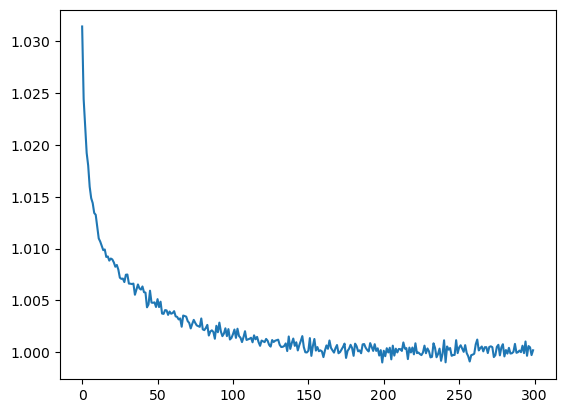

In [27]:
plt.plot(train_losses_cl)

#### Patient Diffusion Model Training

In [28]:
tcga_mlp_diffusion_model = MLPDiffusion(d_in=7776, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [128, 32], "dropout": 0.7})
tcga_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=7776, denoise_fn=tcga_mlp_diffusion_model)

In [29]:
device = torch.device("cuda")
tcga_diff_model.to(device)
optimizer = torch.optim.Adam(tcga_diff_model.parameters(), lr=1e-4)
train_losses_tcga = training_loop(tcga_train_dataloader, tcga_test_dataloader, 300, tcga_diff_model, device, optimizer)

|Epoch 0 | Average training loss: 1.0450759530067444 |
|Epoch 1 | Average training loss: 1.0480094850063324 |
|Epoch 2 | Average training loss: 1.0367399752140045 |
|Epoch 3 | Average training loss: 1.0467972159385681 |
|Epoch 4 | Average training loss: 1.036918193101883 |
|Epoch 5 | Average training loss: 1.037003517150879 |
|Epoch 6 | Average training loss: 1.0269263982772827 |
|Epoch 7 | Average training loss: 1.0266529321670532 |
|Epoch 8 | Average training loss: 1.0261495113372803 |
|Epoch 9 | Average training loss: 1.028094857931137 | Average testing loss: 92.62218475341797
|Epoch 10 | Average training loss: 1.0312925577163696 |
|Epoch 11 | Average training loss: 1.019976019859314 |
|Epoch 12 | Average training loss: 1.0273589491844177 |
|Epoch 13 | Average training loss: 1.0201581716537476 |
|Epoch 14 | Average training loss: 1.0208024680614471 |
|Epoch 15 | Average training loss: 1.019594520330429 |
|Epoch 16 | Average training loss: 1.0228318870067596 |
|Epoch 17 | Average tra

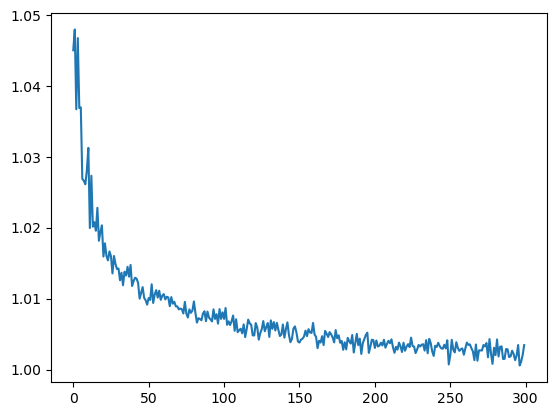

In [30]:
plt.plot(train_losses_tcga)